# LSTM evaluation on the dataset in the filtered frequency domain

## Setting up the evaluation

### Importing the necessary libraries and setting things up

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import sys
import seaborn as sns
import tabulate
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
REPO_ROOT_DIR = "../../../"
sys.path.append(os.path.dirname(REPO_ROOT_DIR))
import src

In [3]:
from src.models import LSTM
from src.features import Filter
from src.features import FFT

In [4]:
csv_path = os.path.join(REPO_ROOT_DIR, "data/raw/csv/")
cfmatrix_path = os.path.join(REPO_ROOT_DIR, "figures/confusion-matrix/frequency-domain/filtered/")

In [5]:
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Setting up the data

### Reading the dataset

In [7]:
dataset = src.data.mit_bih_dataset.MIT_BIH_Dataset(path=csv_path, normalize=True)

In [8]:
X_data = dataset.get_X_data()
y_data = dataset.get_y_data()

### Filtering the X data

In [9]:
filter = Filter.Filter(X_data)
filter.denoise_data()
X_data = filter.get_clean_data()

/usr/local/lib/python3.8/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


### Getting the frequency representation

In [10]:
FFT = FFT.FFT(X_data)
FFT.transform()
X_data = FFT.get_transformed_data()

### Plot a signal from each class

In [11]:
class_0_index = np.where(y_data == 0)[0][0]
class_1_index = np.where(y_data == 1)[0][0]
class_2_index = np.where(y_data == 2)[0][0]
class_3_index = np.where(y_data == 3)[0][0]
class_4_index = np.where(y_data == 4)[0][0]
classes_index = [class_0_index, class_1_index, class_2_index, class_3_index, class_4_index]

legendas = ["Sem arritmia cardíaca", "Bloqueio de ramo esquerdo", "Bloqueio de ramo direito", "Contração atrial prematura", "Contração ventricular prematura"]

In [12]:
t = np.linspace(0,1,180)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


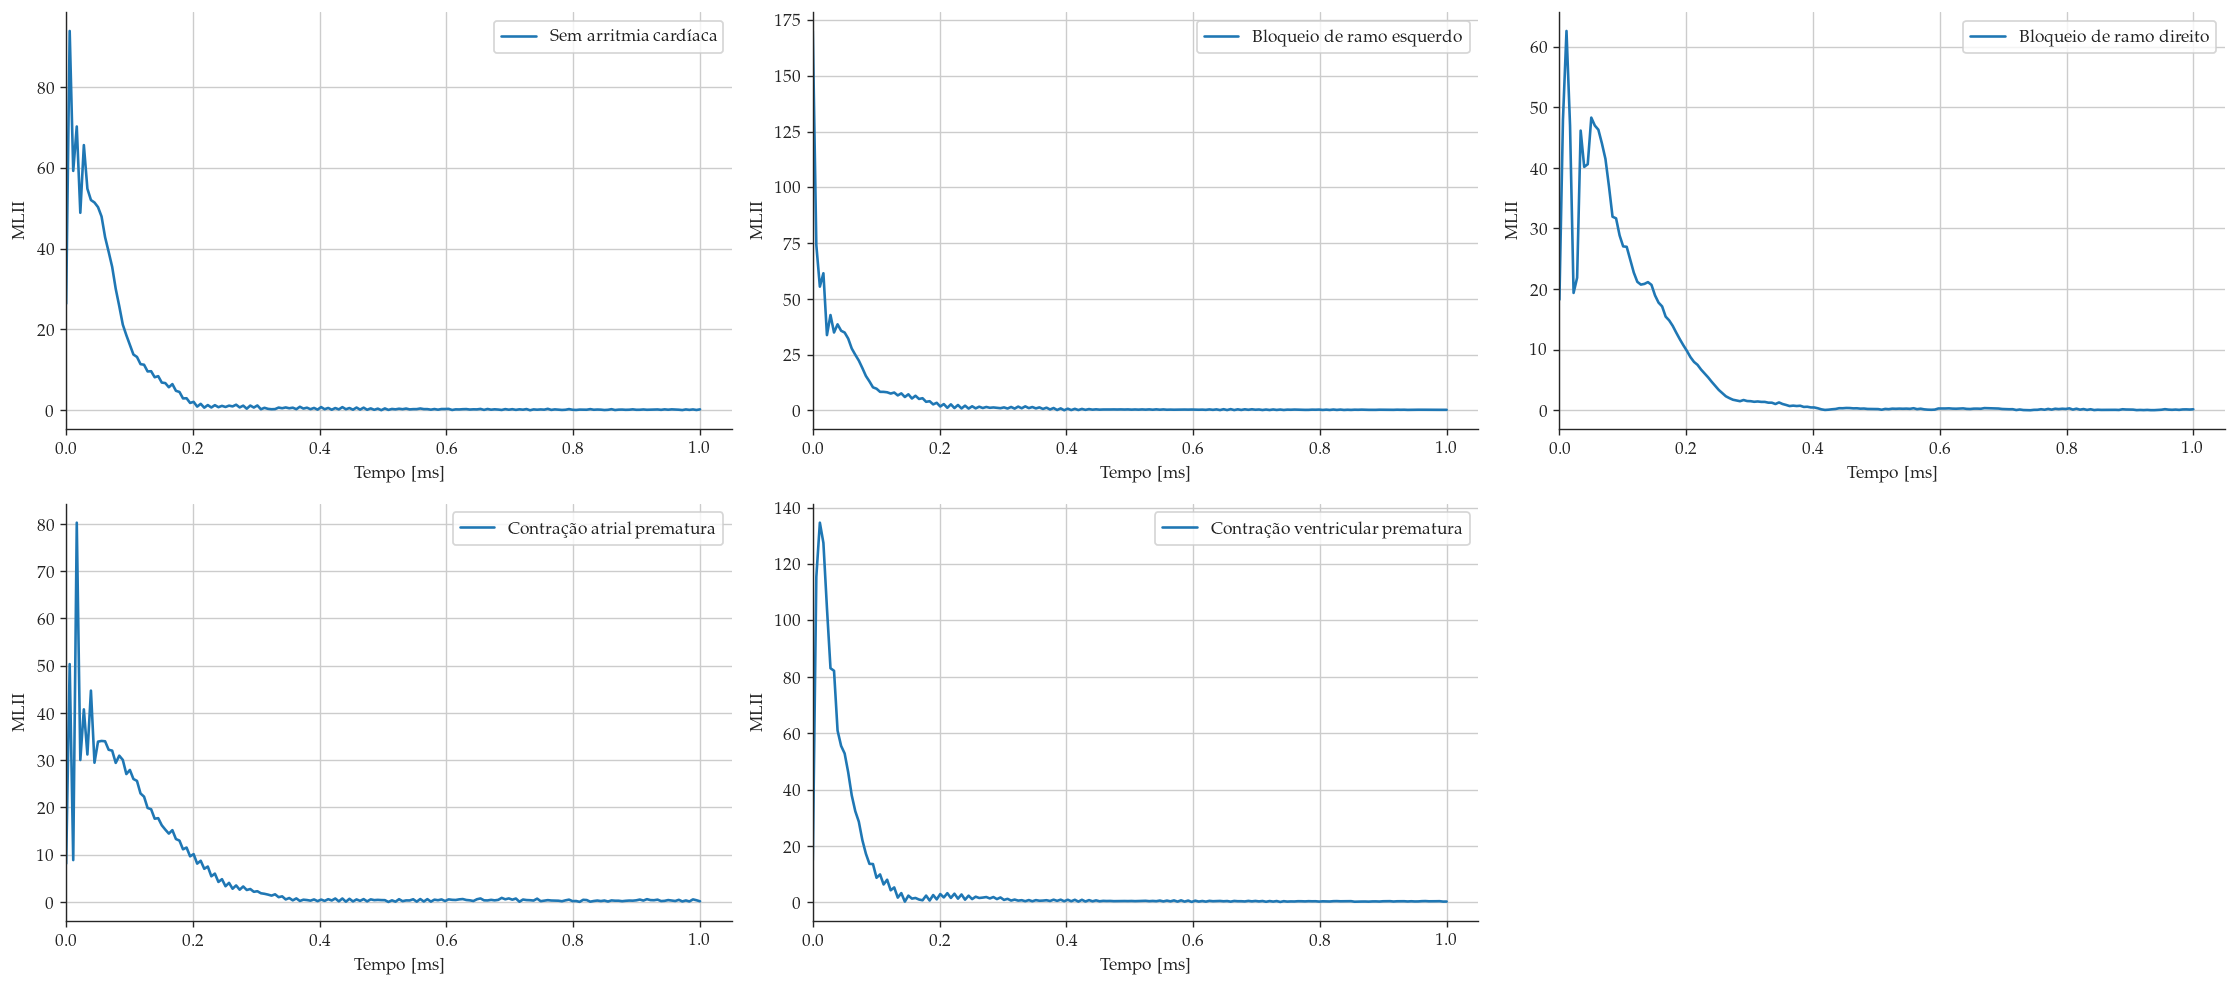

In [13]:
fig = plt.figure(tight_layout=True, figsize=(18,8))

for index, name in enumerate(classes_index):
    ax = fig.add_subplot(2, 3, index+1)
    ax.plot(t, X_data[name], label=legendas[index])
    ax.grid(True)
    ax.legend()
    ax.set_xlim(0,)
    ax.set_ylabel("MLII")
    ax.set_xlabel("Tempo [ms]")

sns.despine()
fig.savefig(REPO_ROOT_DIR + "figures/signals/filtered-frequency-signals-normalized.pdf")

### Creating the test, train and validation set

In [14]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_data, y_data, random_state=42, test_size=0.25, stratify=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.1, stratify=True)

## Evaluating the models

## LSTM

In [15]:
lstm_model = LSTM.LSTM_Model(X_train, y_train, X_val, y_val, n_labels=5, n_neurons=100)
lstm_metrics = lstm_model.eval_model(X_test, y_test, n_eval_times=5)

100/100 [==============================] - 0s 1ms/step


In [16]:
print("F-medida:", round(lstm_metrics[0][0], 4), "+/-", round(lstm_metrics[0][1], 4),"| Acurácia:", round(lstm_metrics[1][0], 4), "+/-", round(lstm_metrics[1][1], 4))

F-medida: 0.9253 +/- 0.0039 | Acurácia: 0.9247 +/- 0.0037


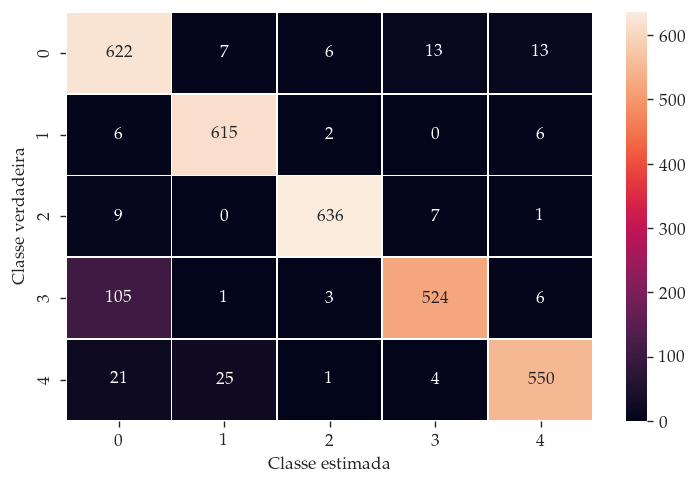

In [17]:
lstm_model.confusion_matrix(y_test, cfmatrix_path)